In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model, losses

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

4422102/4422102 [==============================] - 1s 0us/step


In [5]:
# vytvoreni párů obrázku - pro tretning !!!!
def create_pairs(images, digit_labels):
    digit_indices = [np.where(digit_labels == i)[0] for i in range(10)]
    pairs = []
    pair_labels = []

    for idx1 in range(len(images)):
        # Výběr stejného obrázku
        x1 = images[idx1]
        label1 = digit_labels[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = images[idx2]
        
        pairs += [[x1, x2]]
        pair_labels += [1]
        
        # Výběr náhodného obrázku
        label2 = np.random.randint(0, 10)
        while label2 == label1:
            label2 = np.random.randint(0, 10)

        idx2 = np.random.choice(digit_indices[label2])
        x2 = images[idx2]
        
        pairs += [[x1, x2]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)

In [6]:
# vytvoření trénovacích a testovacích párů - reálný dataset!!!
train_pairs, train_y = create_pairs(train_images, train_labels)
test_pairs, test_y = create_pairs(test_images, test_labels)

train_pairs = np.expand_dims(train_pairs, axis=-1)
test_pairs = np.expand_dims(test_pairs, axis=-1)

# Vytvareni modelu

In [10]:
# Vytvořeni base-modelu
input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='sigmoid')(x)
base_network = Model(inputs=input, outputs=x)

2023-06-16 12:20:50.648560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-16 12:20:50.648734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


In [11]:
# neuronová sít je rozstepena - zpracovavam dve vetve - které jsou ale siamske - stejne telo , jiné vstupy - jiná hlava:

input_a = layers.Input(shape=(28, 28))
input_b = layers.Input(shape=(28, 28))

processed_a = base_network(input_a)
processed_b = base_network(input_b)


In [12]:
# vypoctu rozdíl mezi vetvi A a vetvi B:

distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
output = layers.Dense(1, activation='sigmoid')(distance)

In [13]:
# Tohle je az realny model - vlastne pomeruje výsledky dvou neuronových sítí!!

model = Model([input_a, input_b], output)

In [14]:


# kompilace a trening
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y, batch_size=32, epochs=3, validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y))


Epoch 1/3


2023-06-16 12:24:49.920890: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-16 12:24:50.238649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3749/3750 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.8899

2023-06-16 12:25:31.867949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 45s 11ms/step - loss: 0.2744 - accuracy: 0.8899 - val_loss: 0.2149 - val_accuracy: 0.9104
Epoch 2/3
3750/3750 [==============================] - 42s 11ms/step - loss: 0.1721 - accuracy: 0.9313 - val_loss: 0.1856 - val_accuracy: 0.9234
Epoch 3/3
3750/3750 [==============================] - 41s 11ms/step - loss: 0.1363 - accuracy: 0.9461 - val_loss: 0.1760 - val_accuracy: 0.9293


625/625 [==============================] - 3s 4ms/step


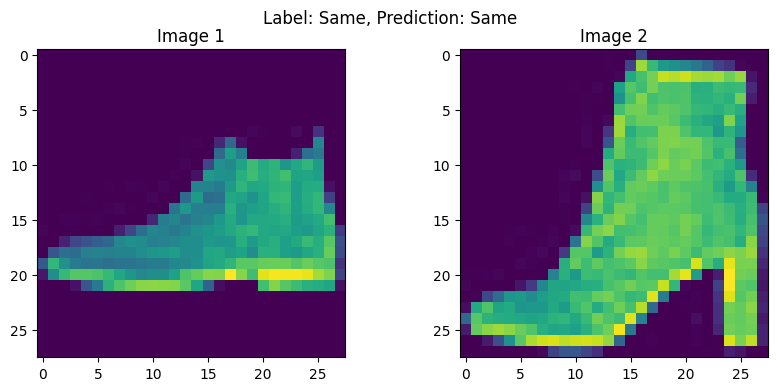

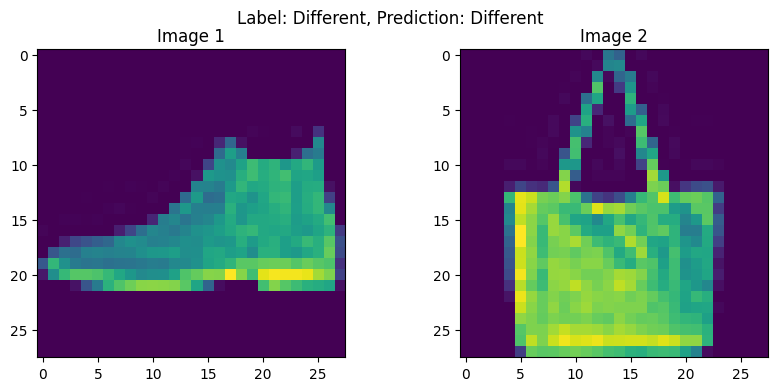

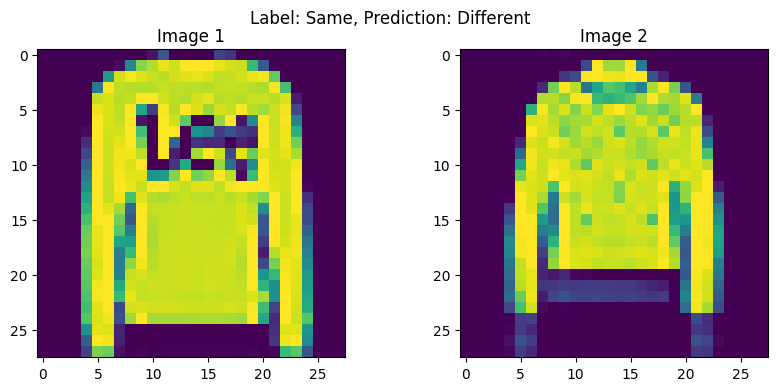

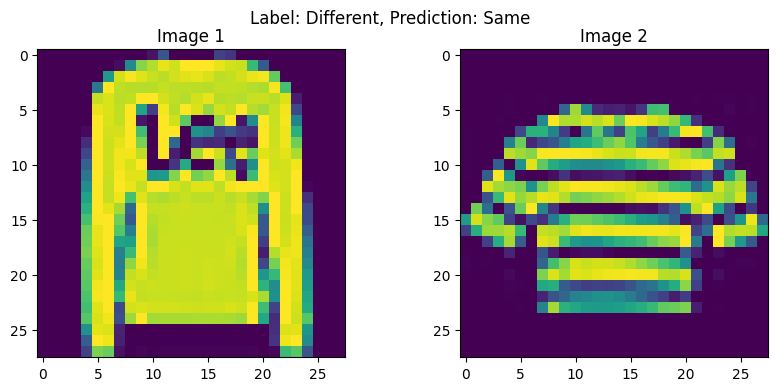

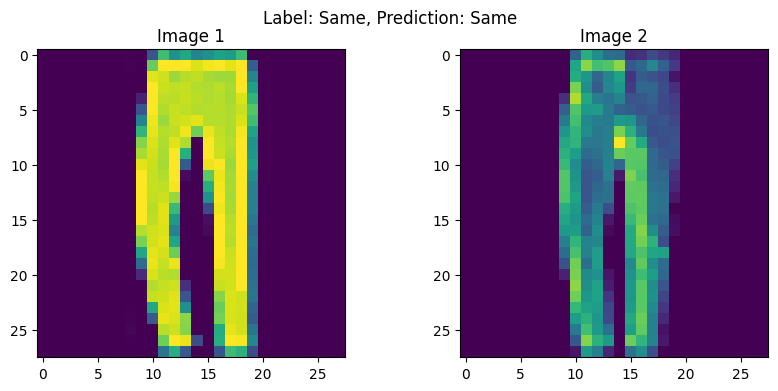

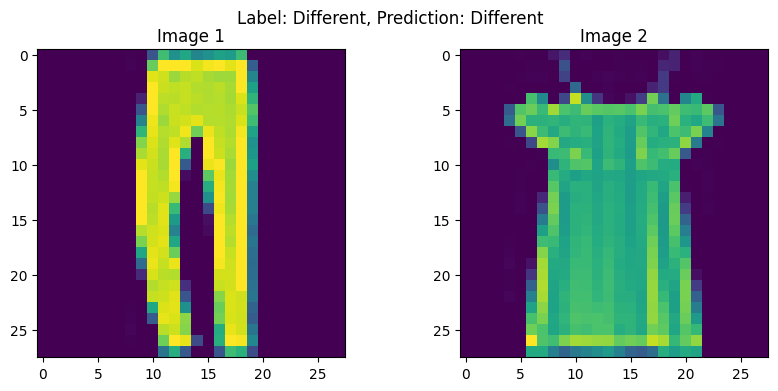

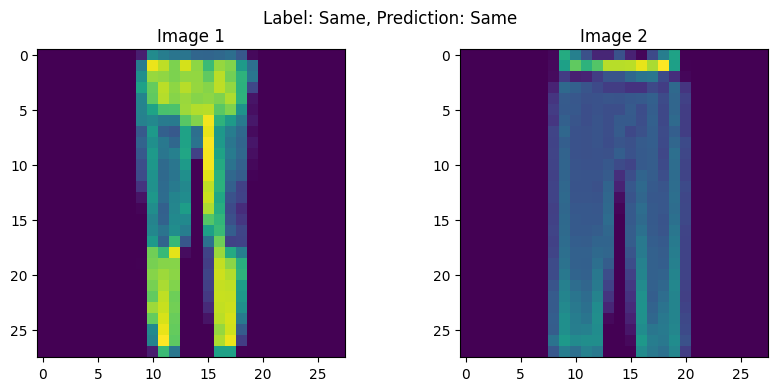

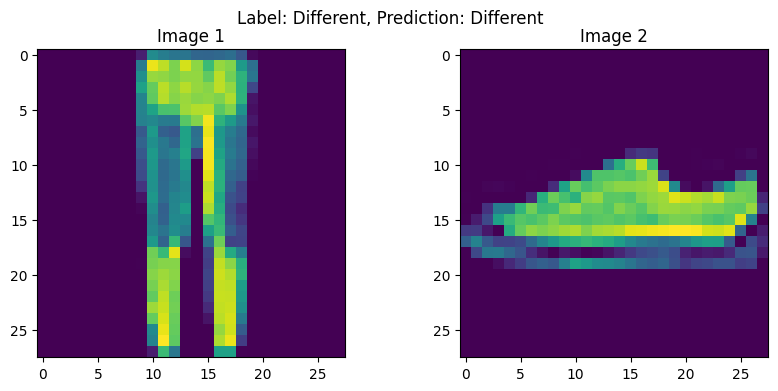

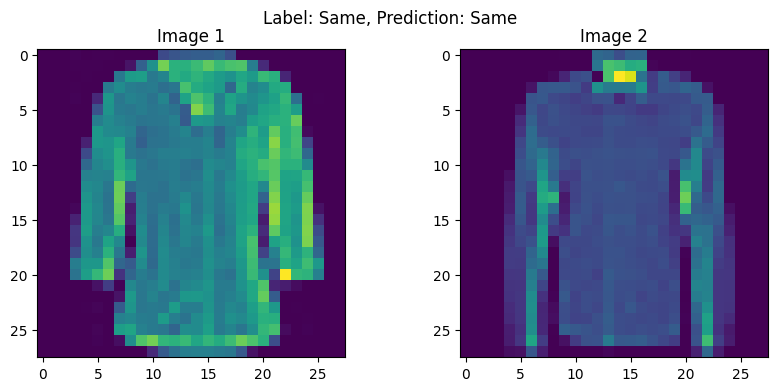

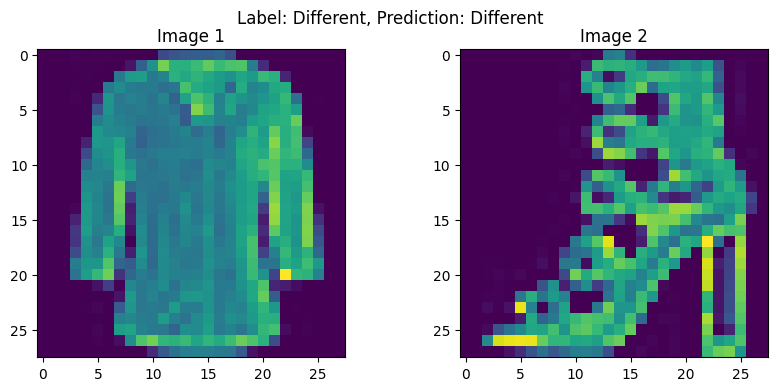

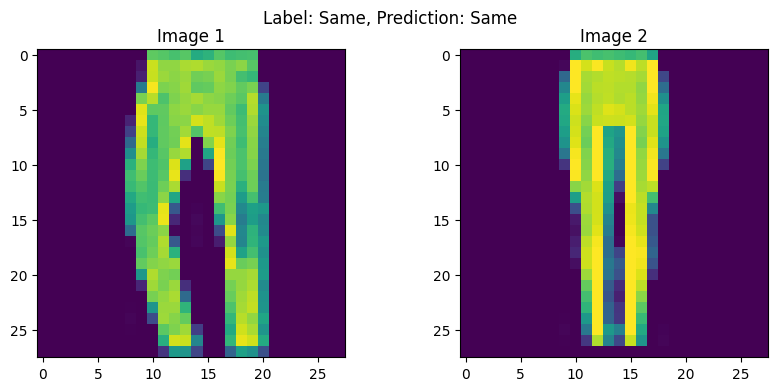

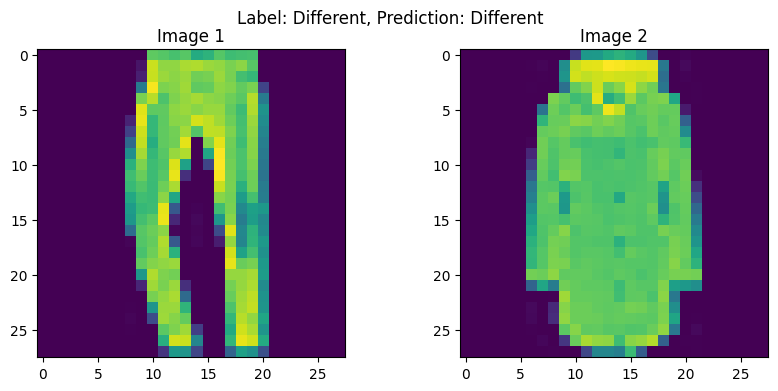

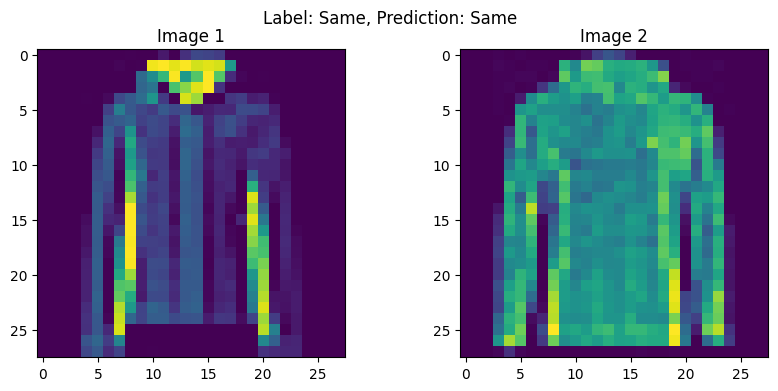

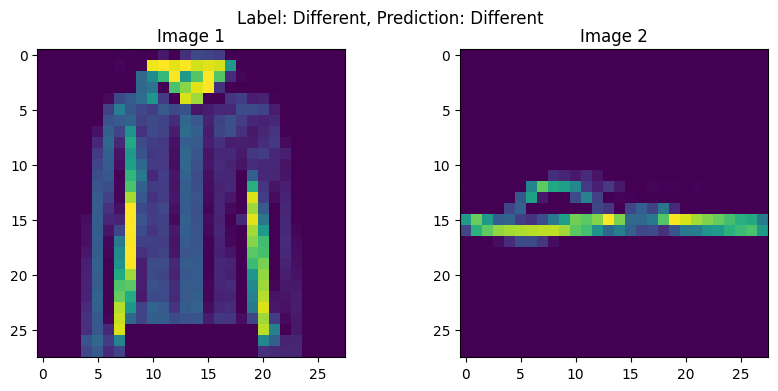

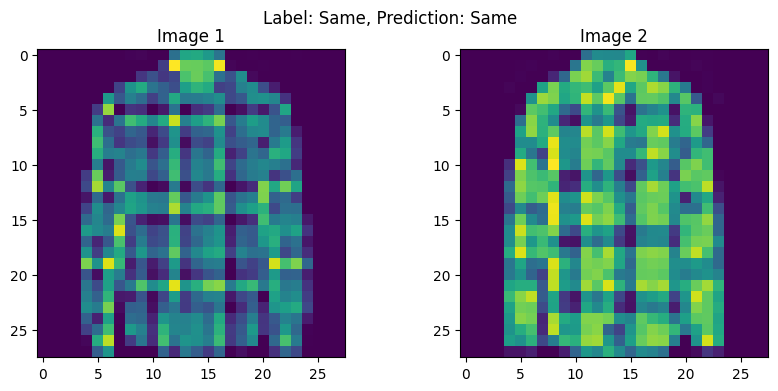

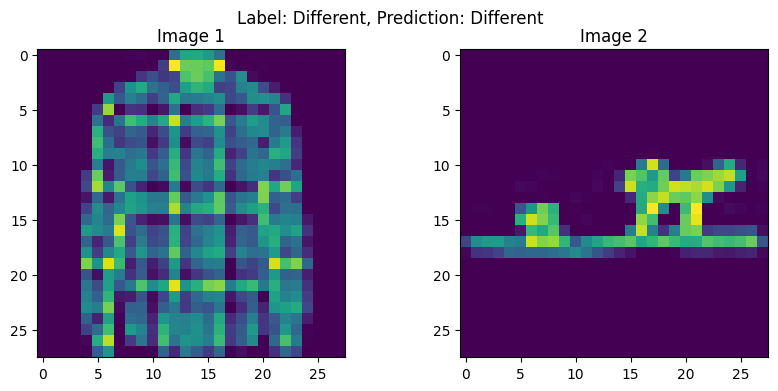

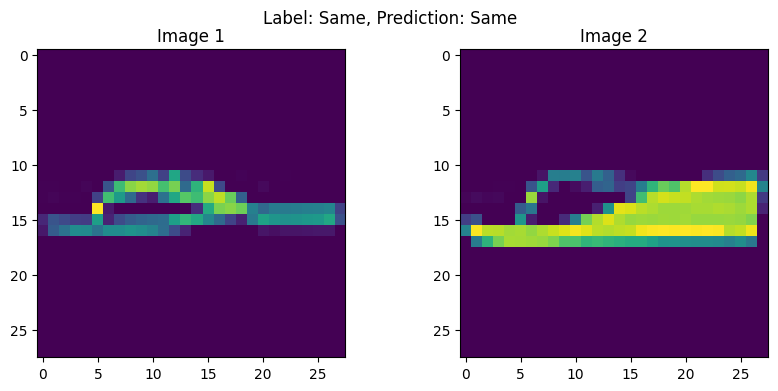

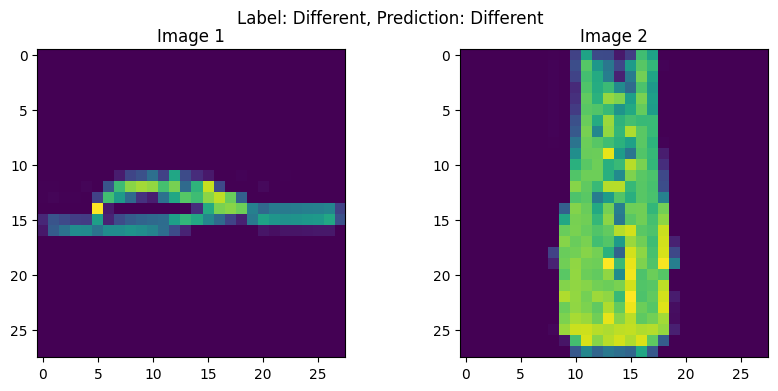

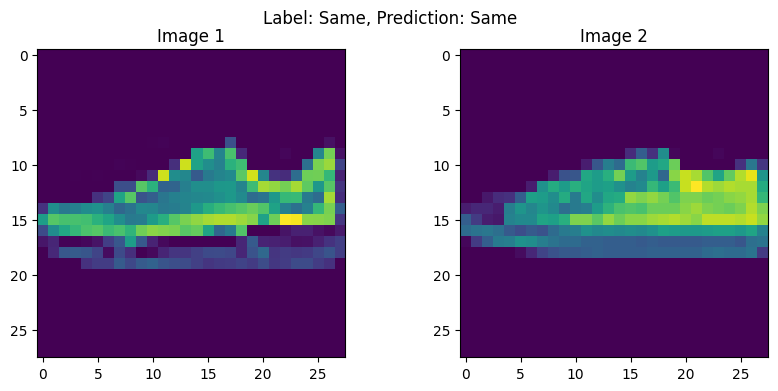

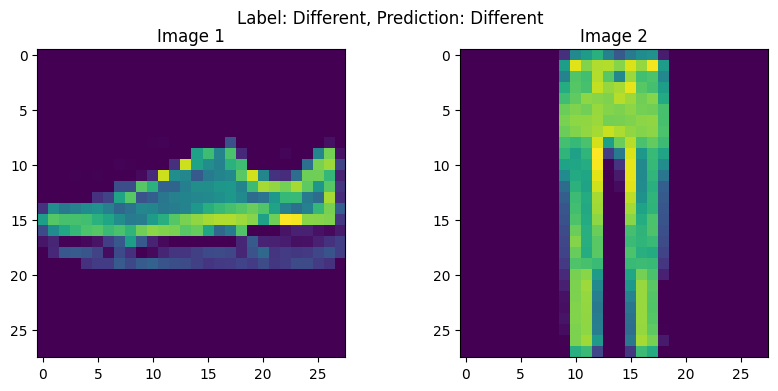

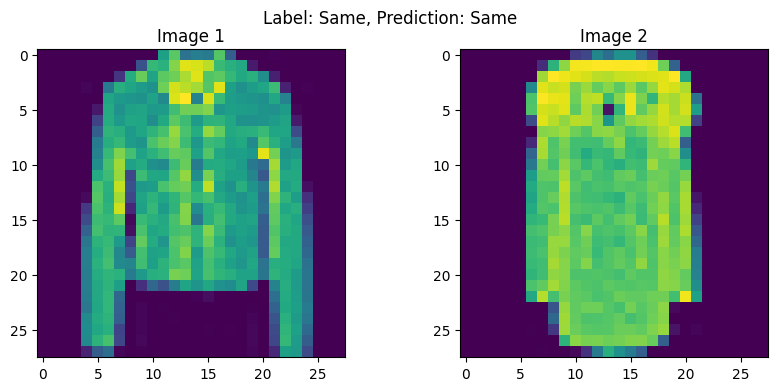

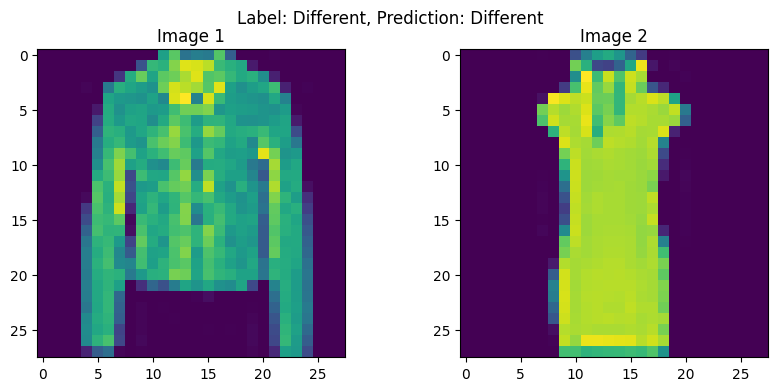

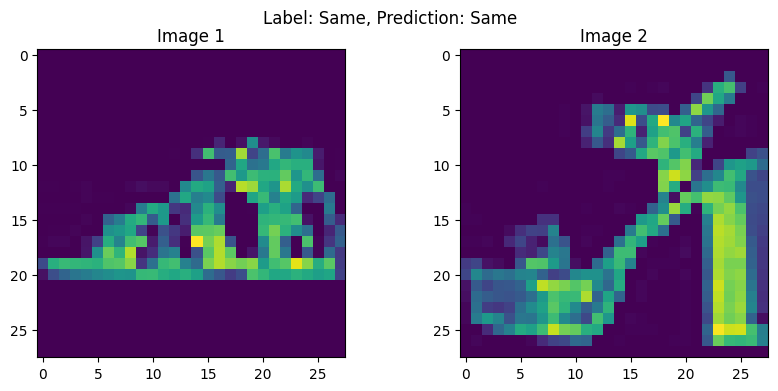

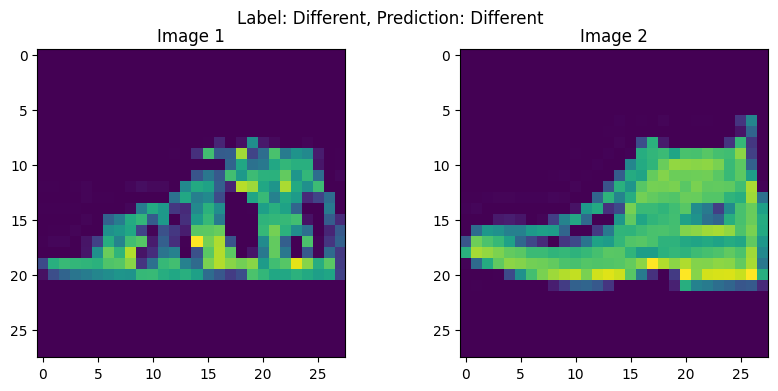

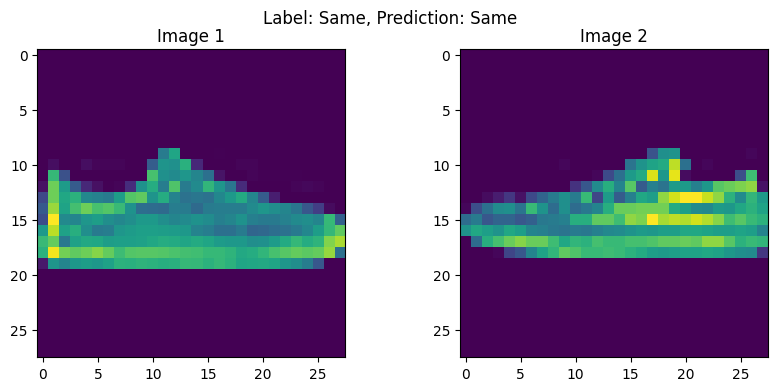

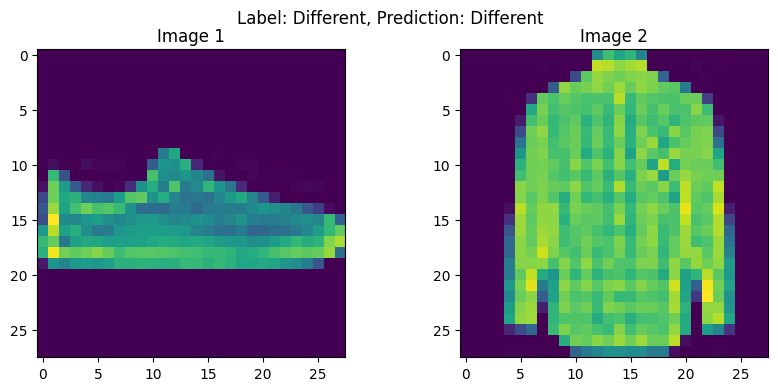

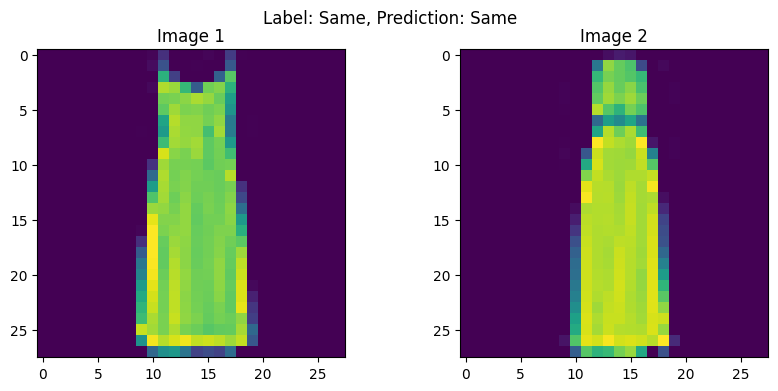

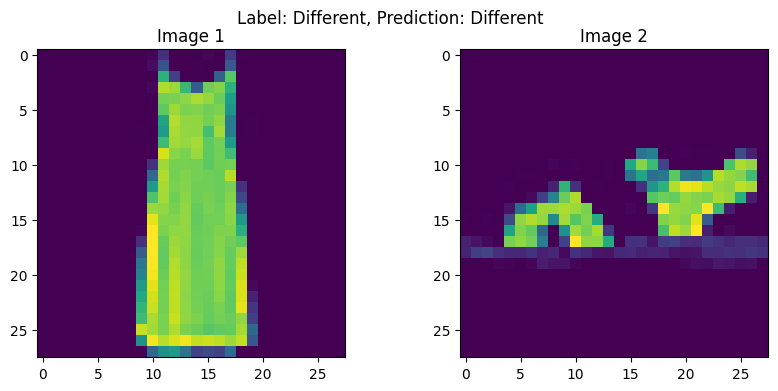

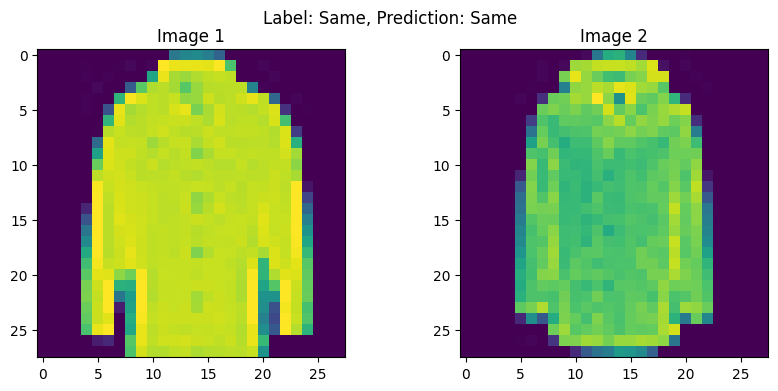

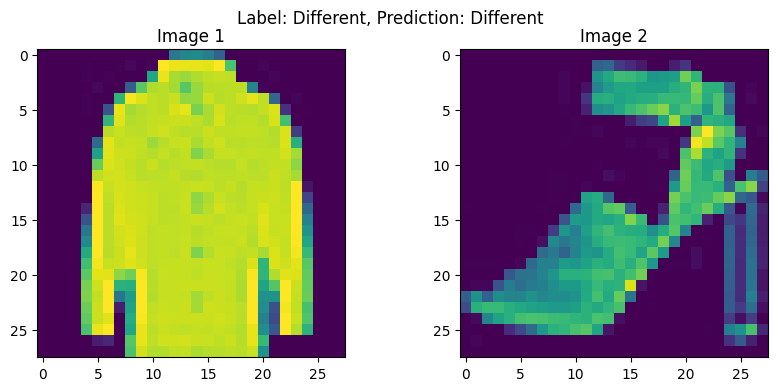

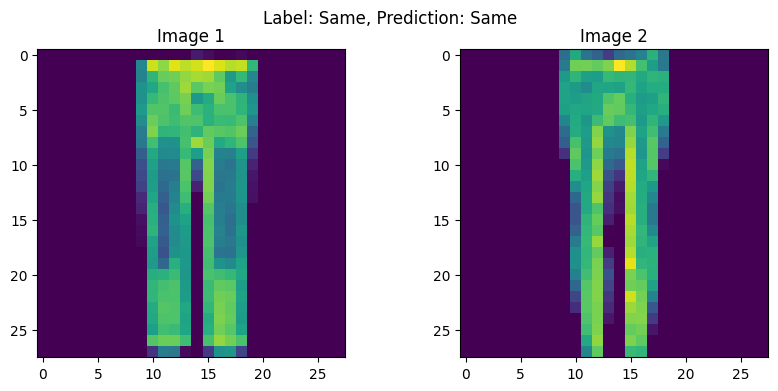

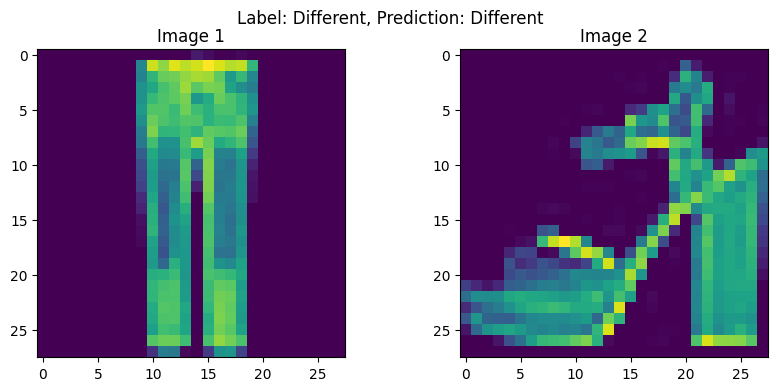

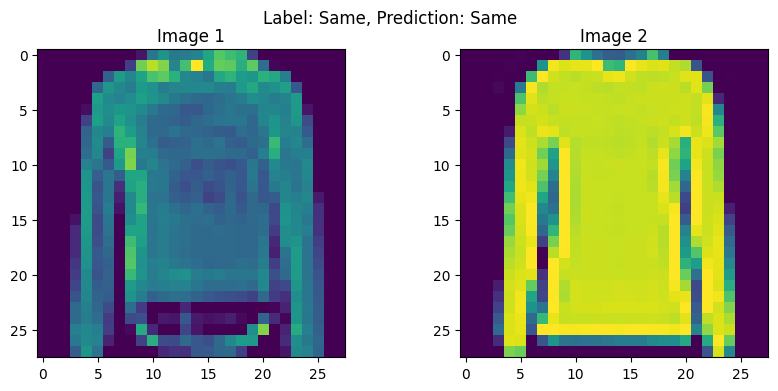

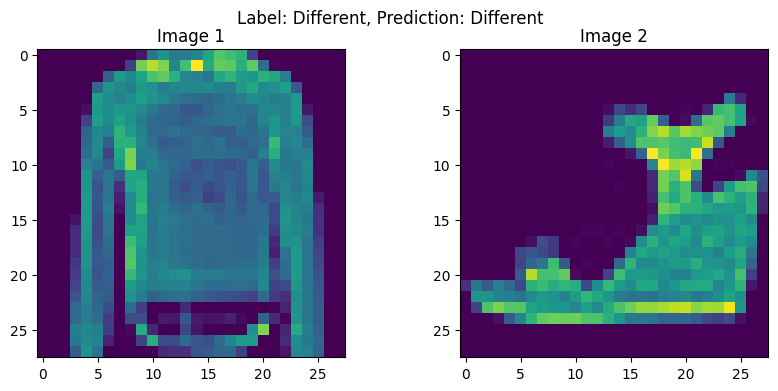

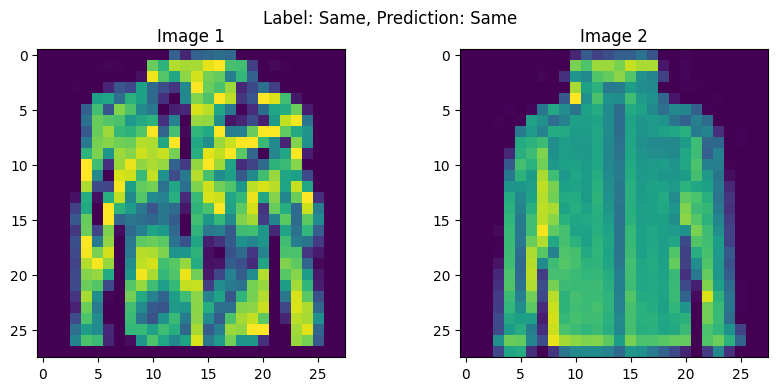

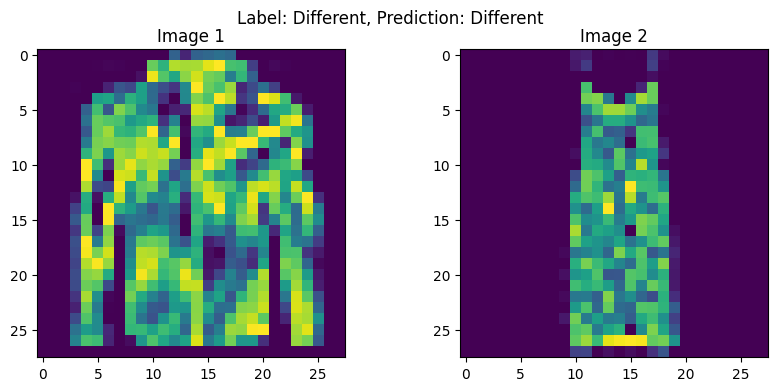

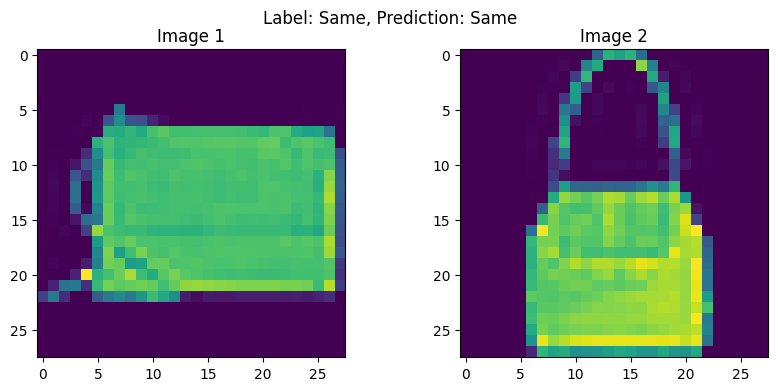

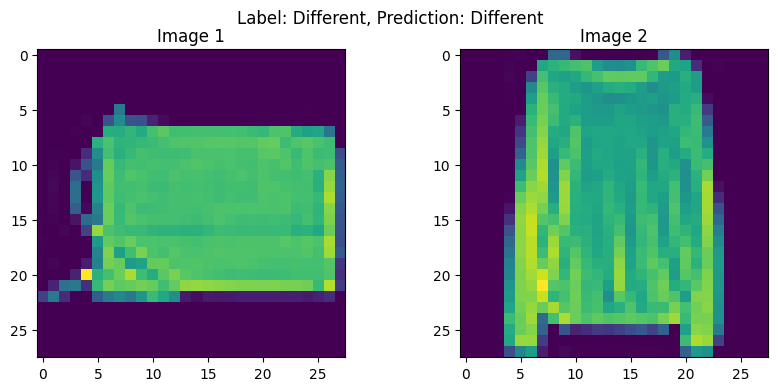

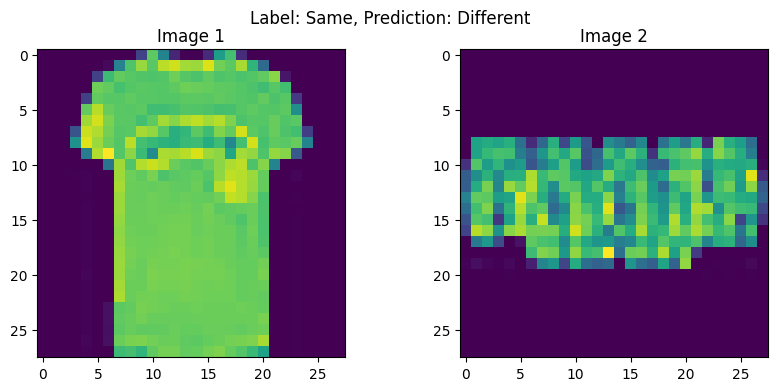

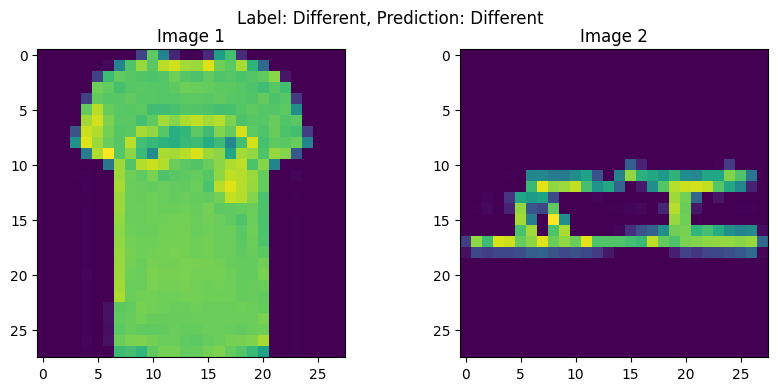

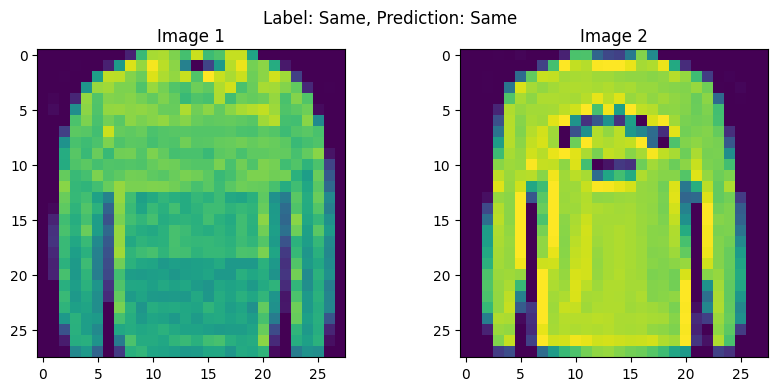

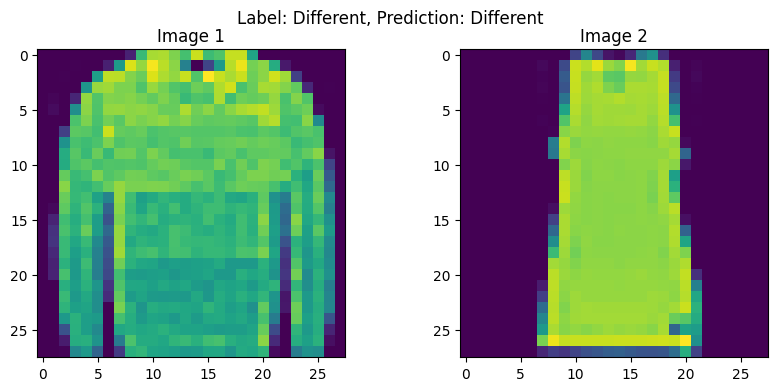

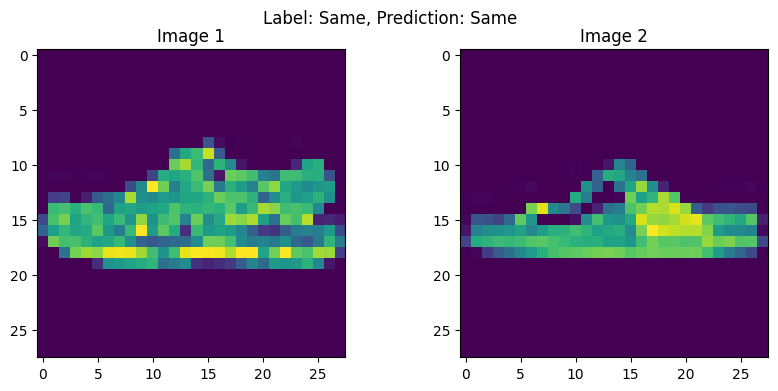

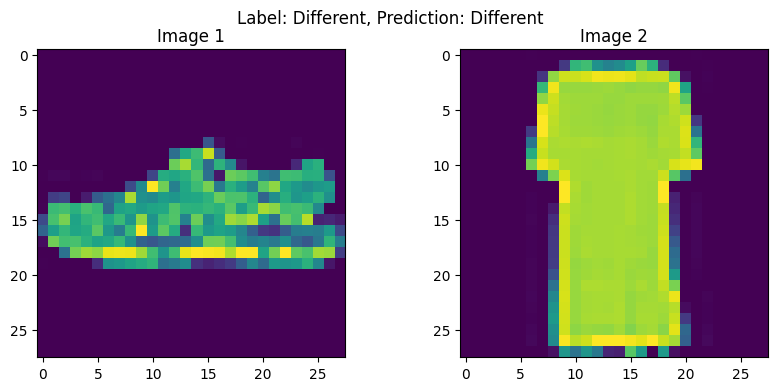

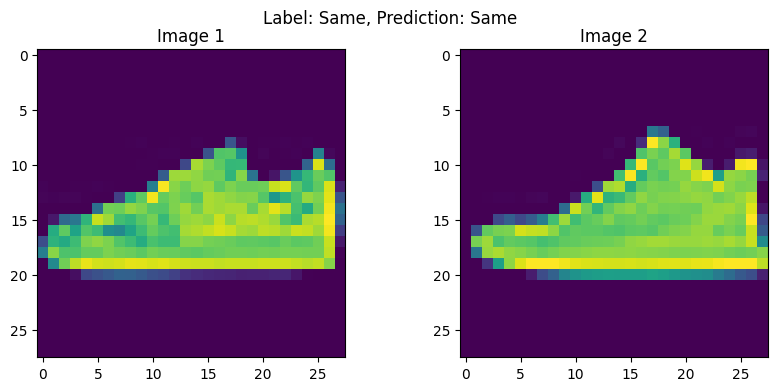

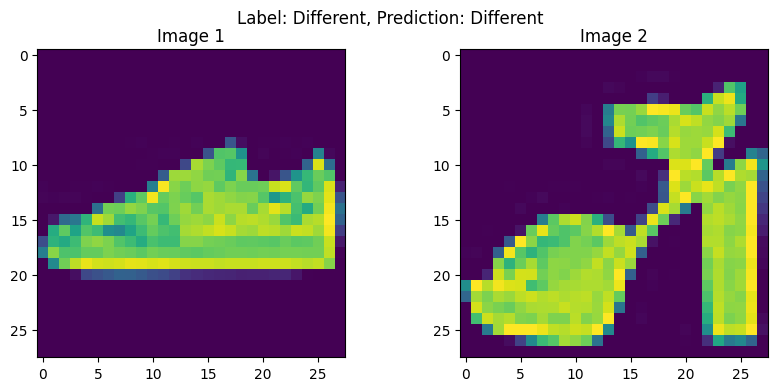

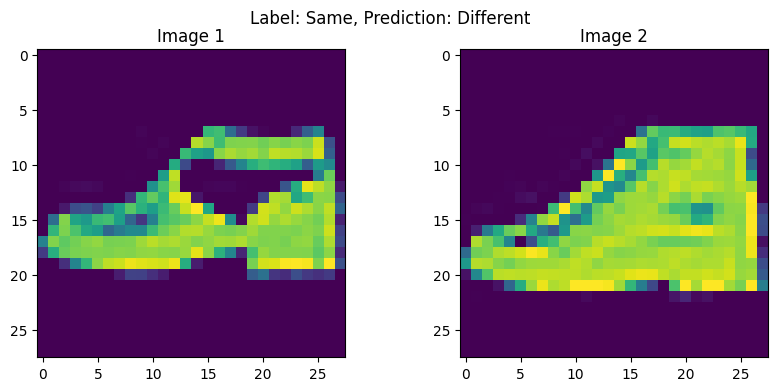

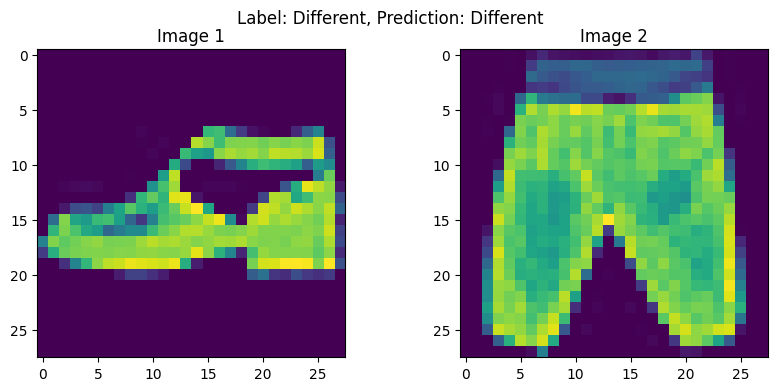

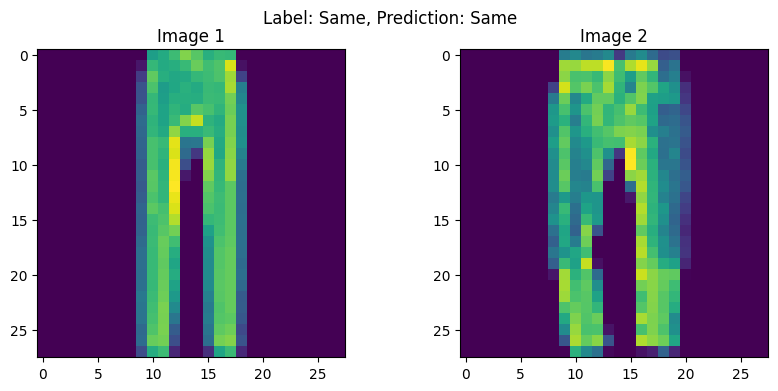

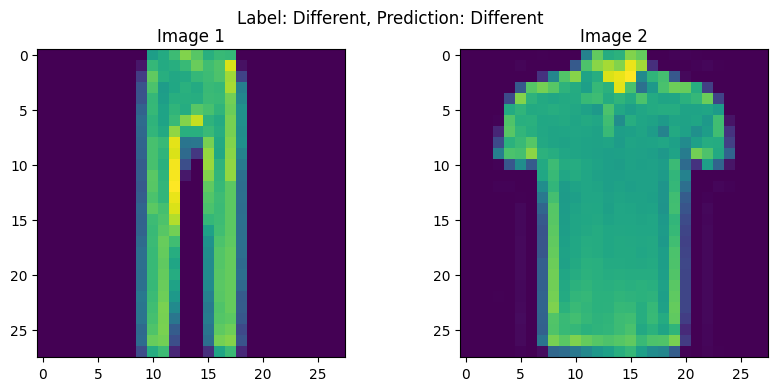

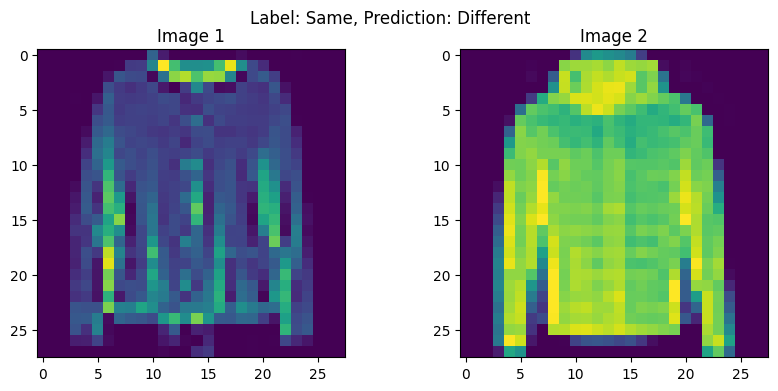

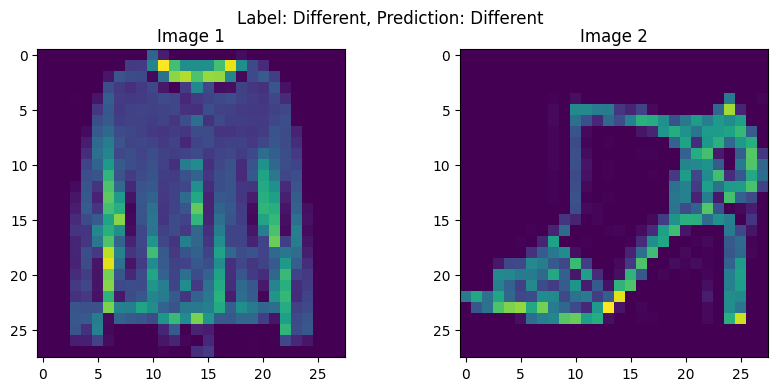

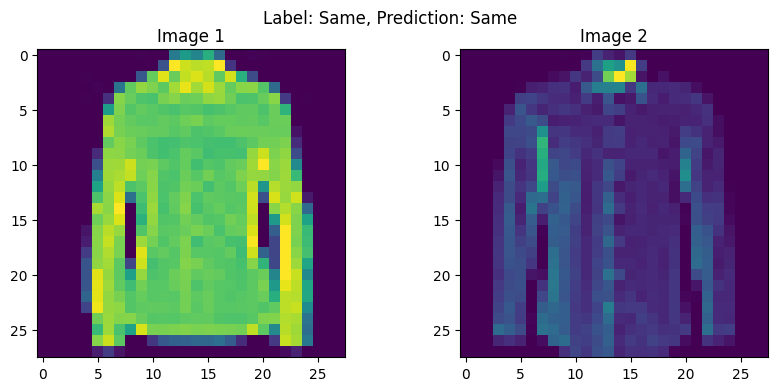

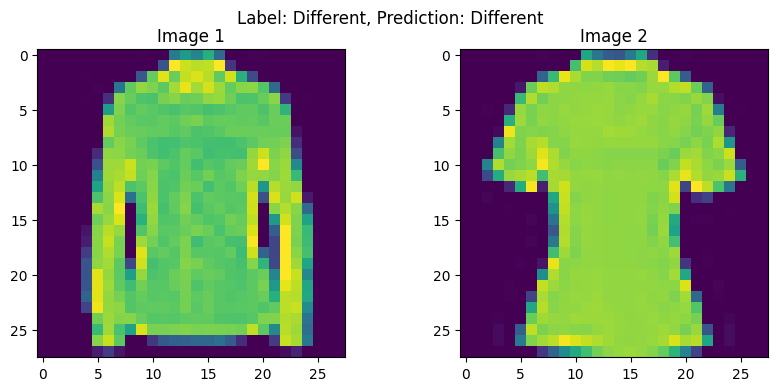

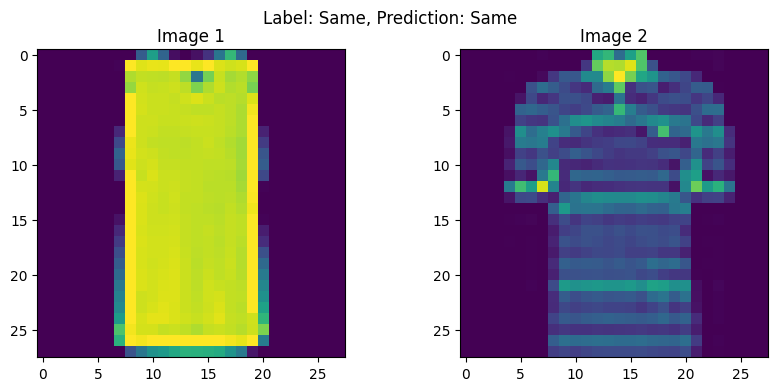

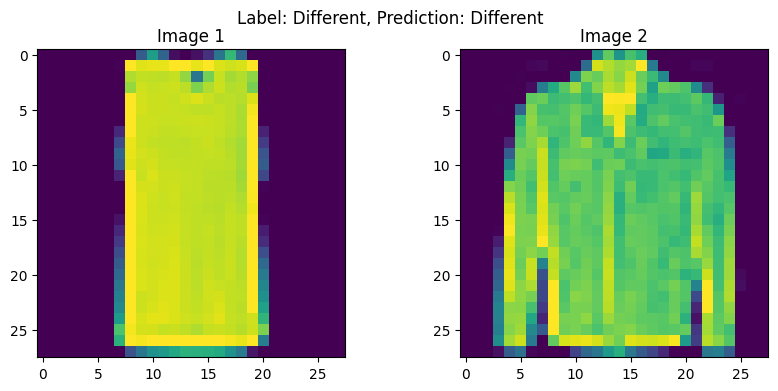

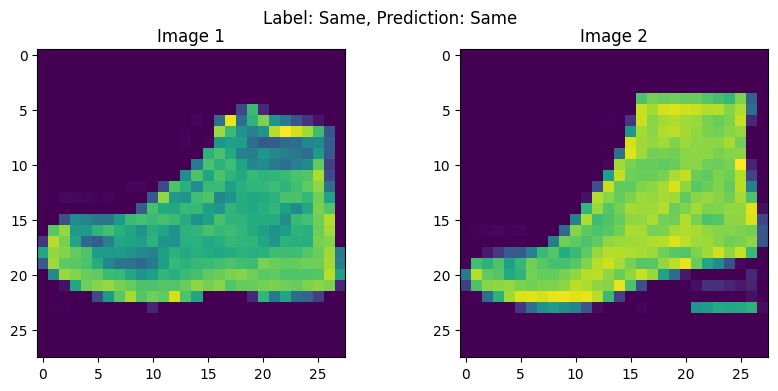

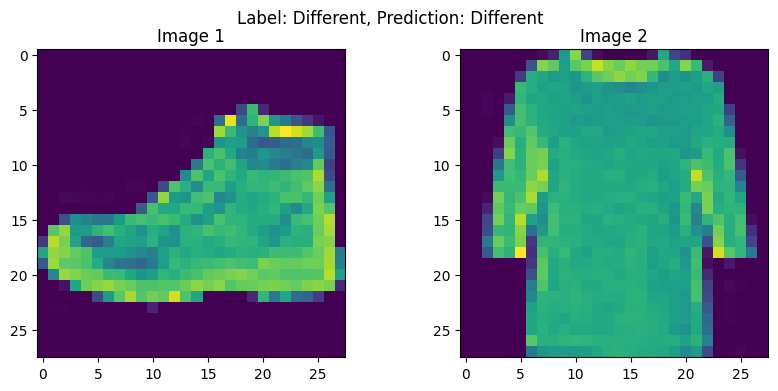

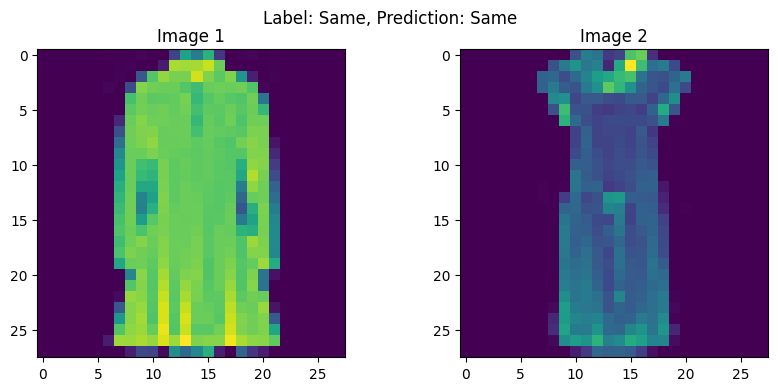

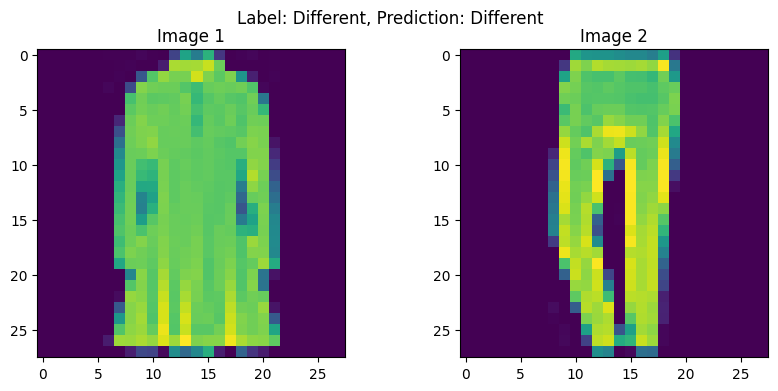

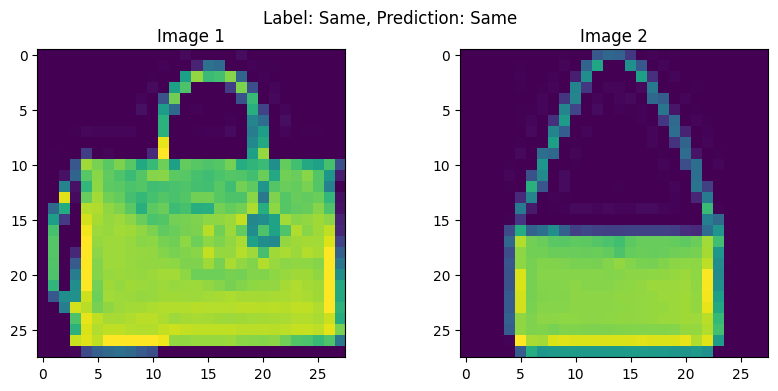

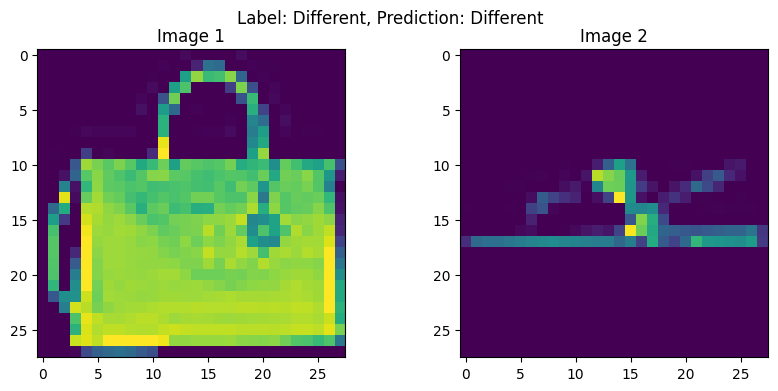

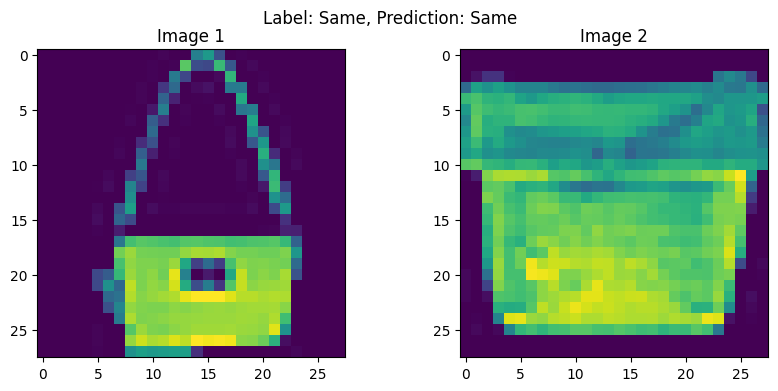

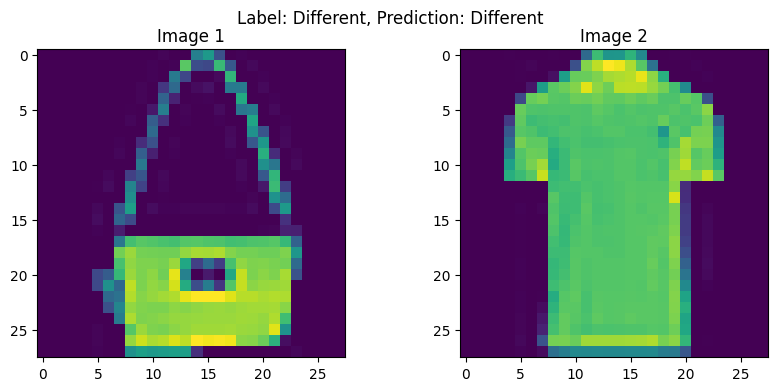

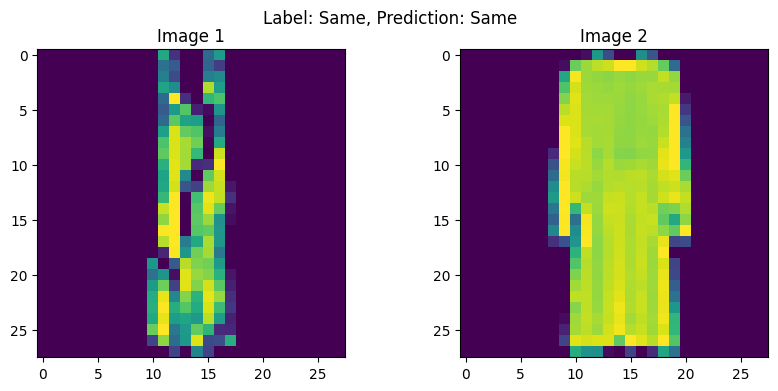

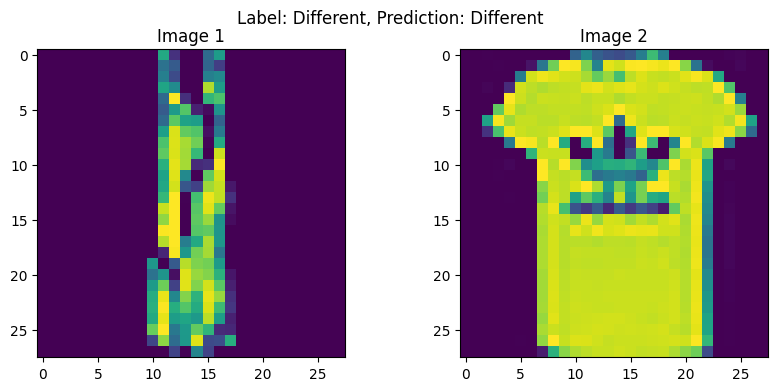

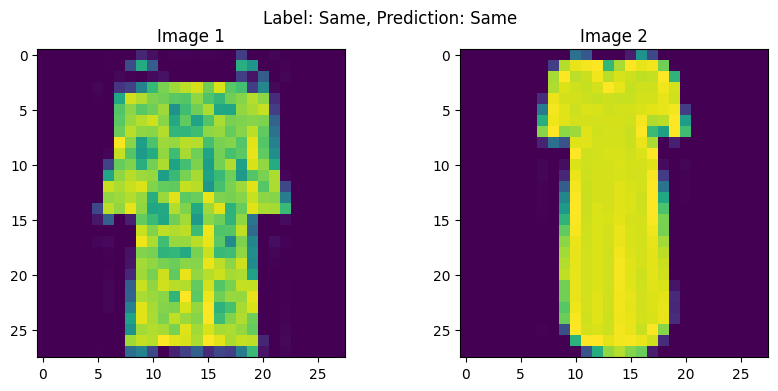

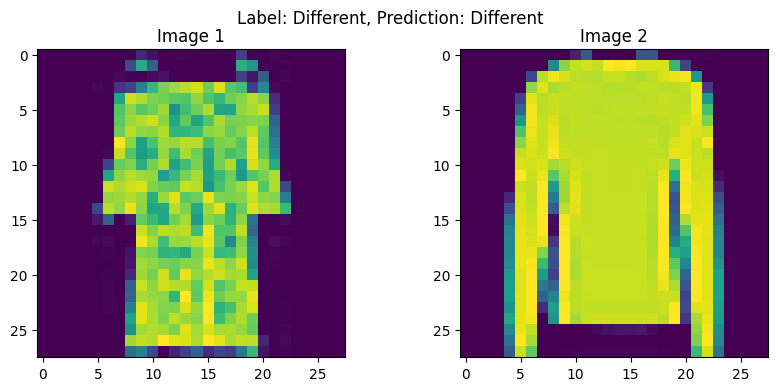

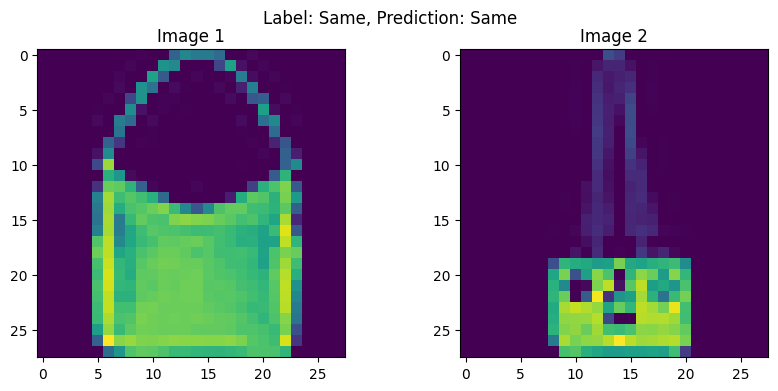

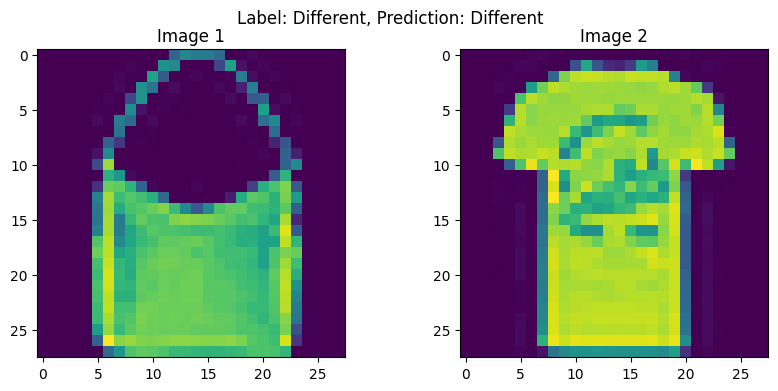

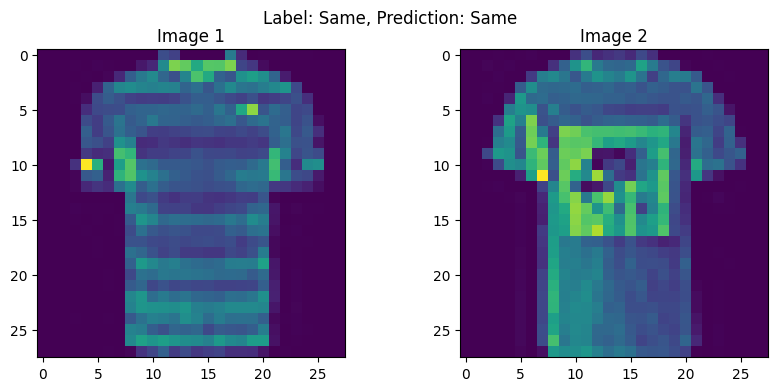

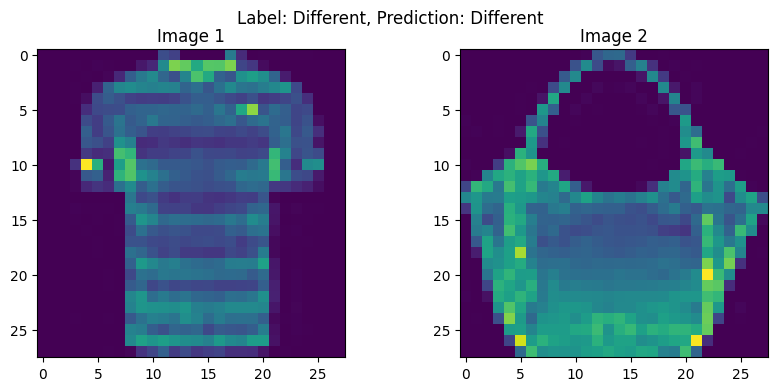

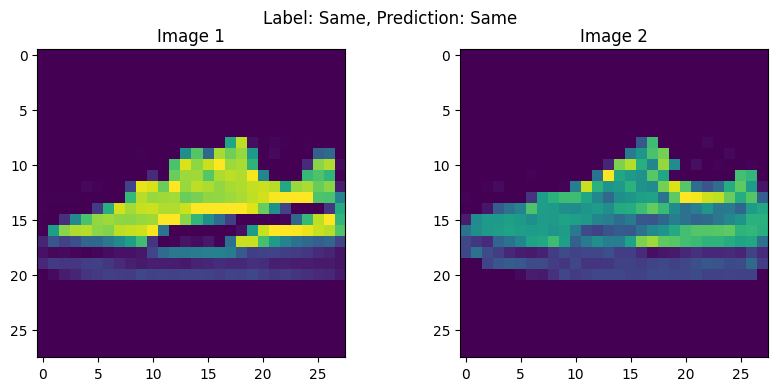

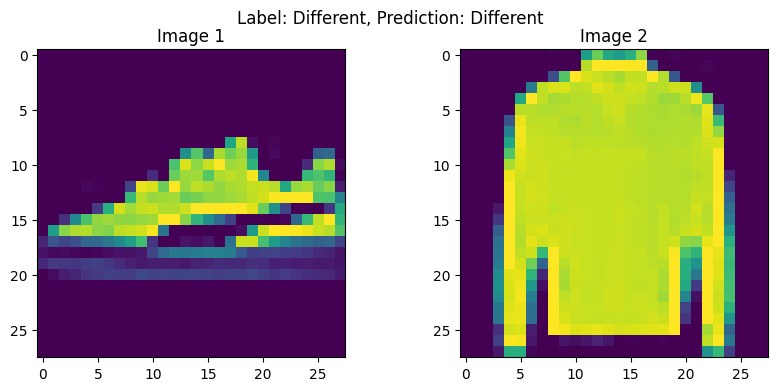

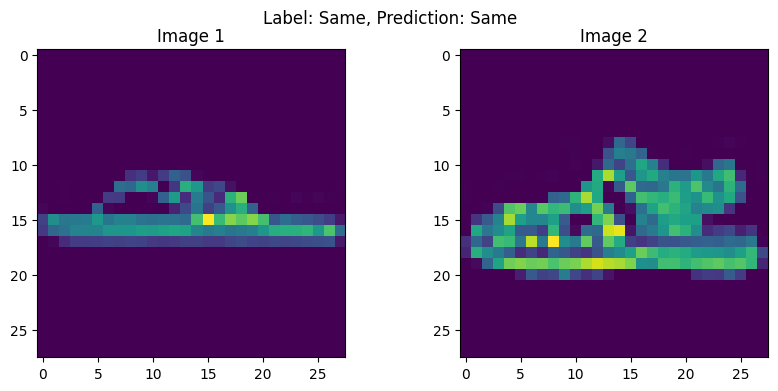

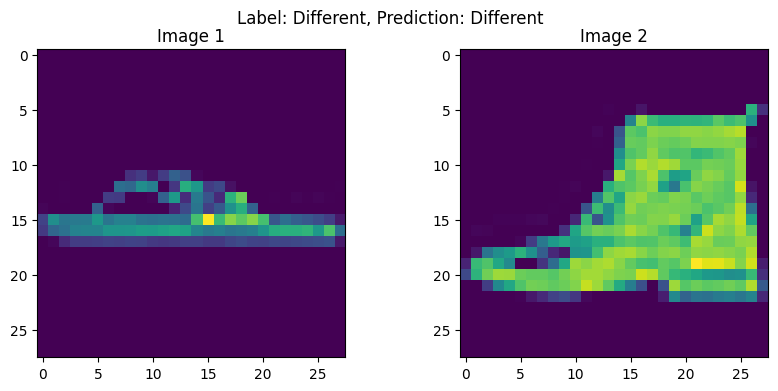

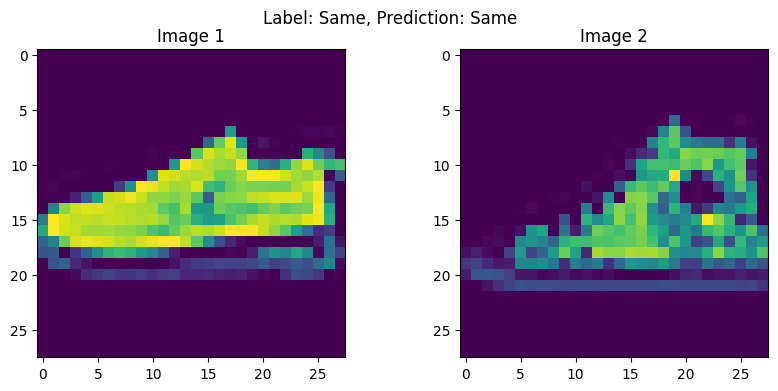

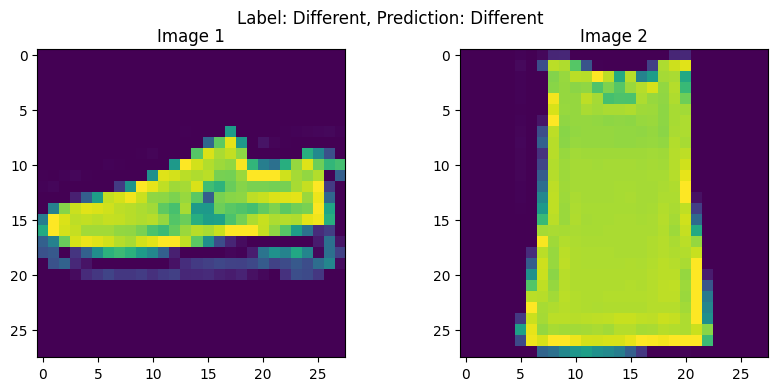

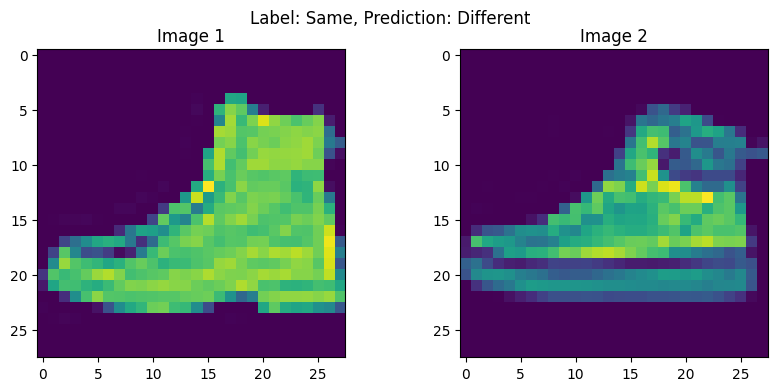

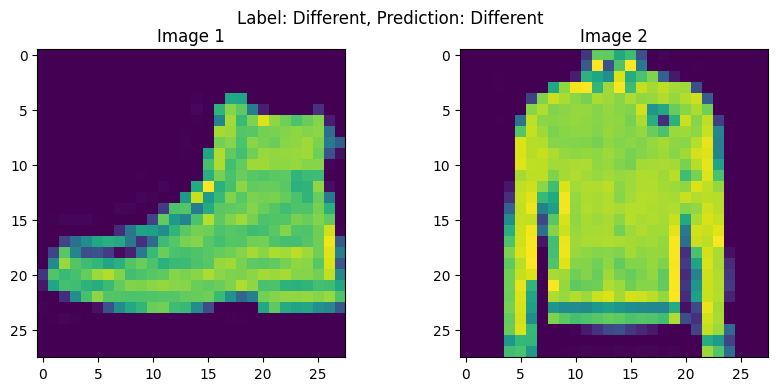

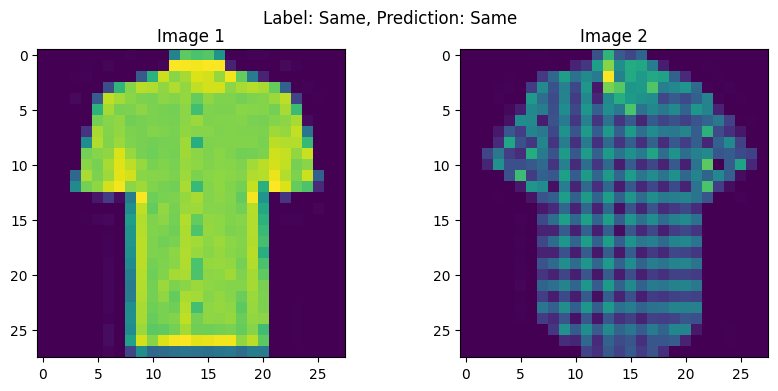

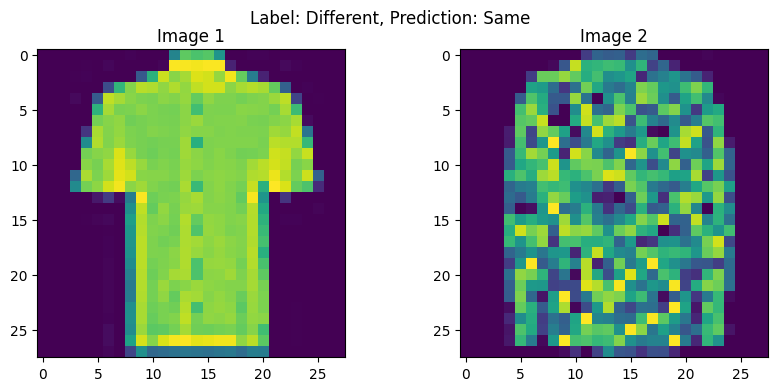

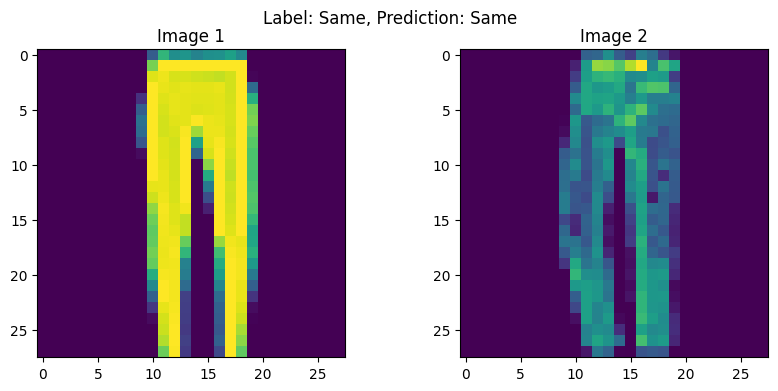

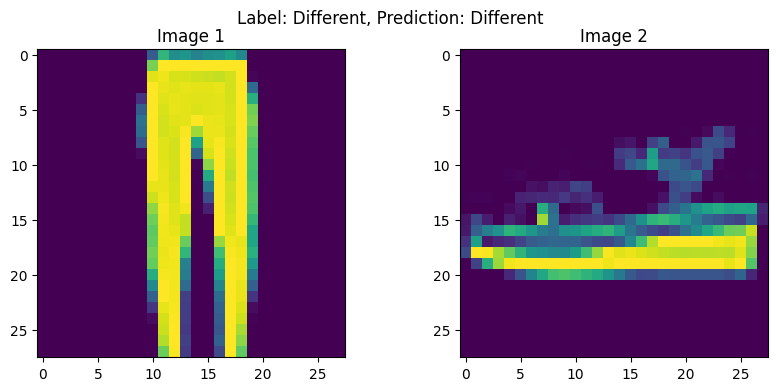

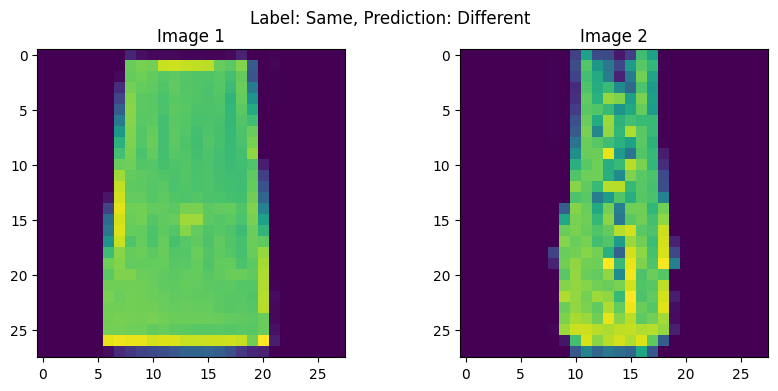

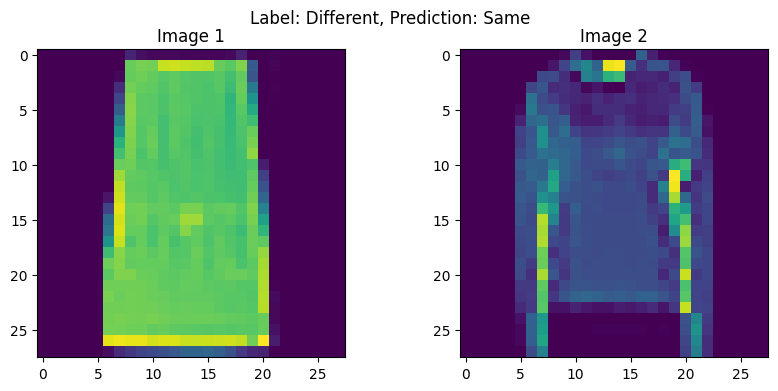

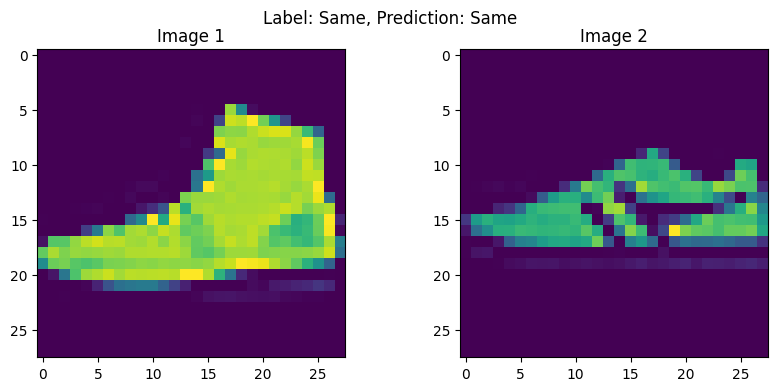

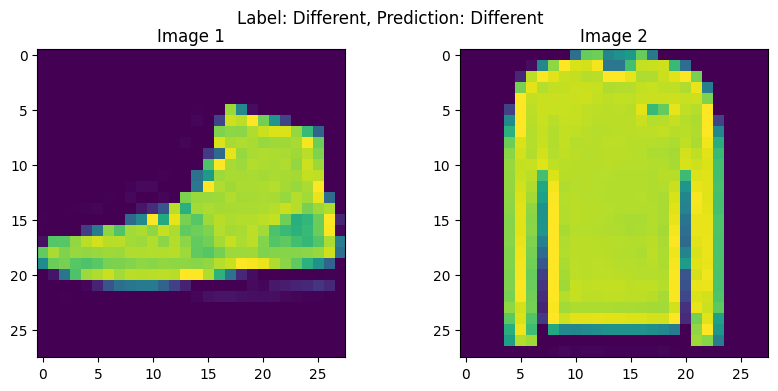

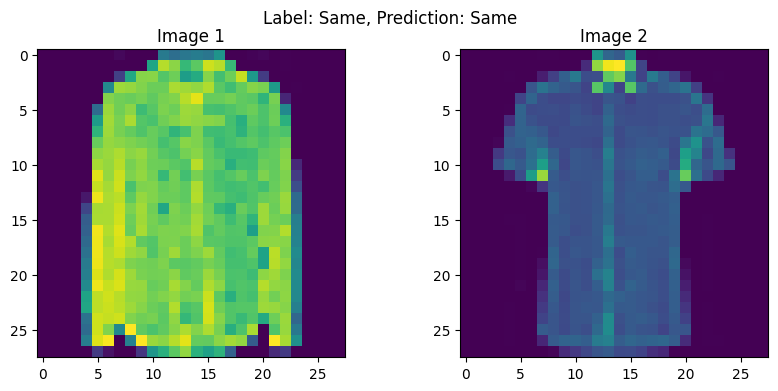

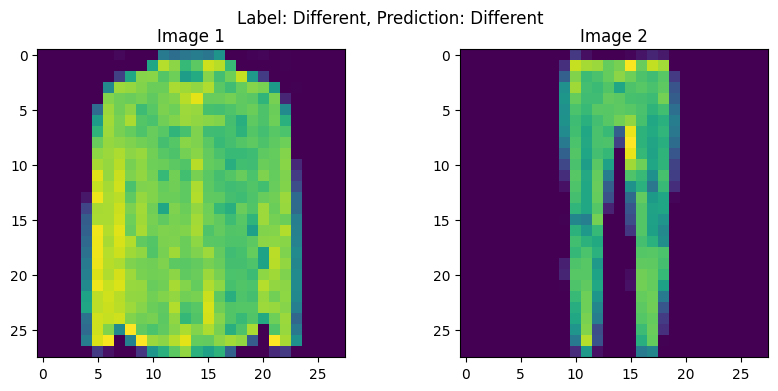

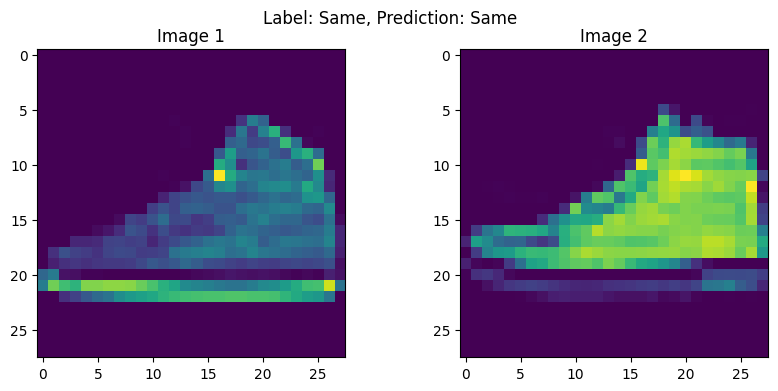

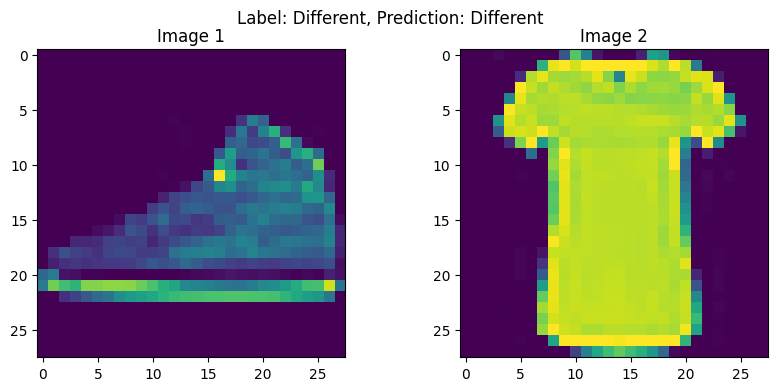

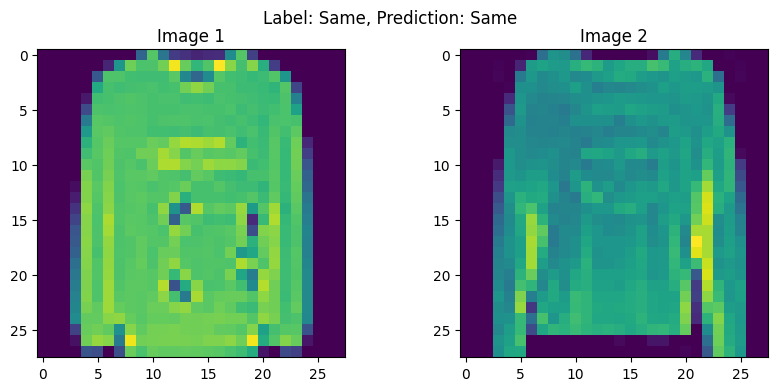

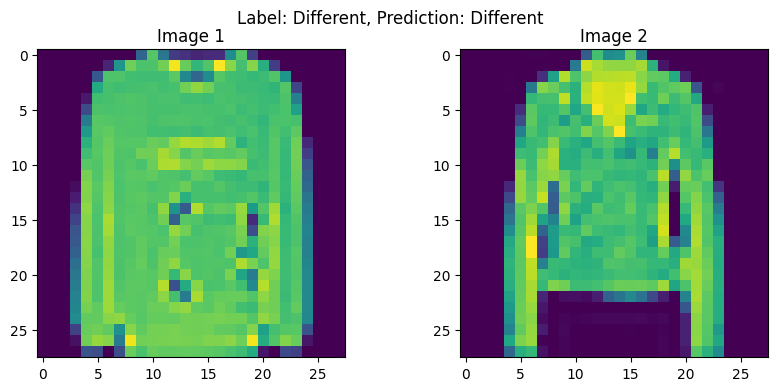

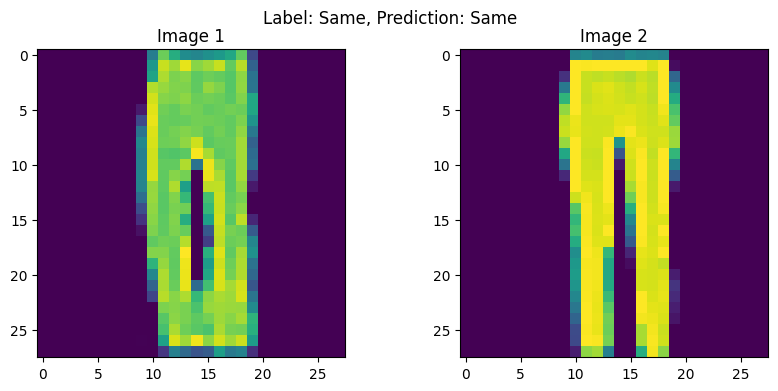

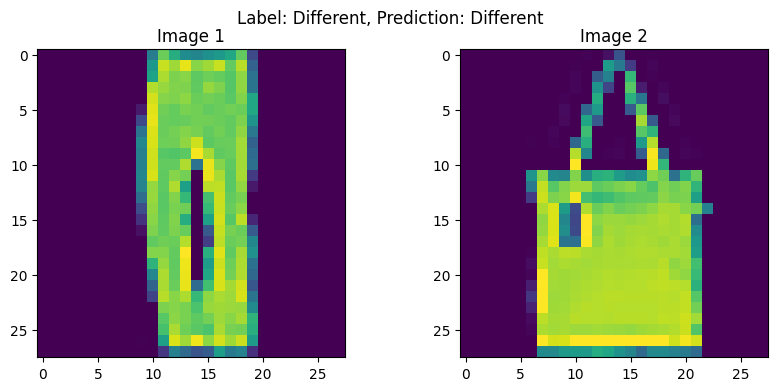

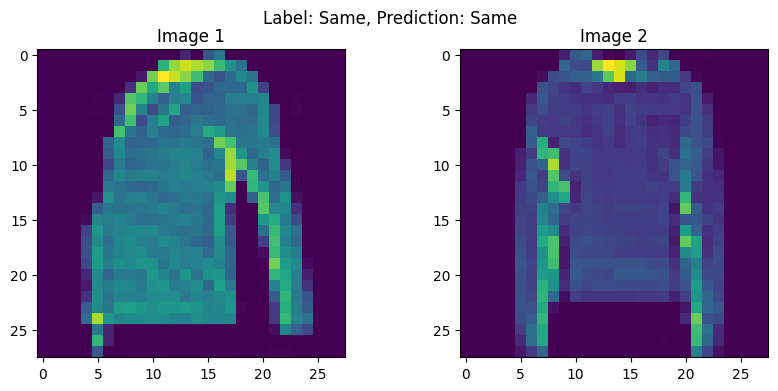

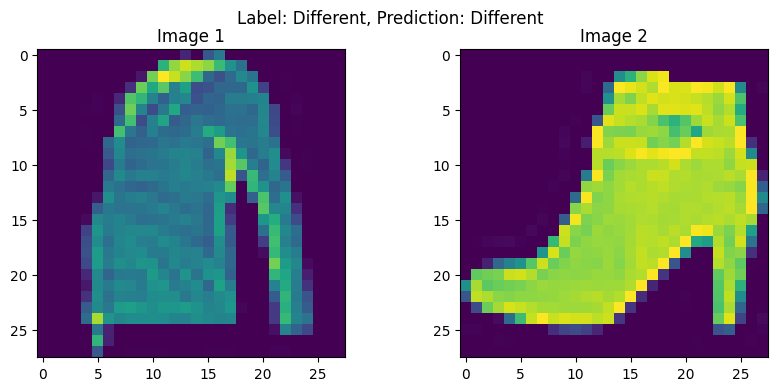

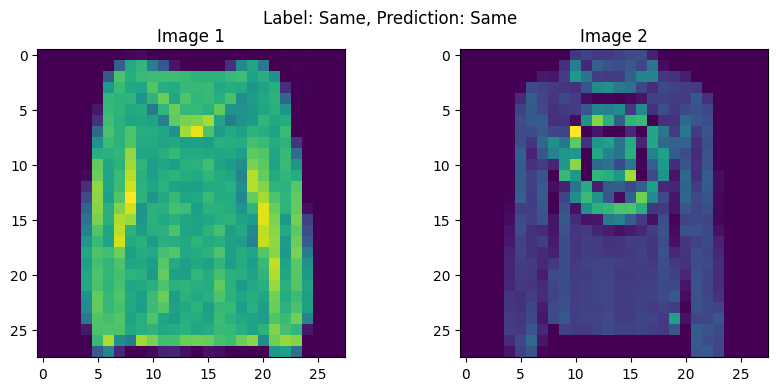

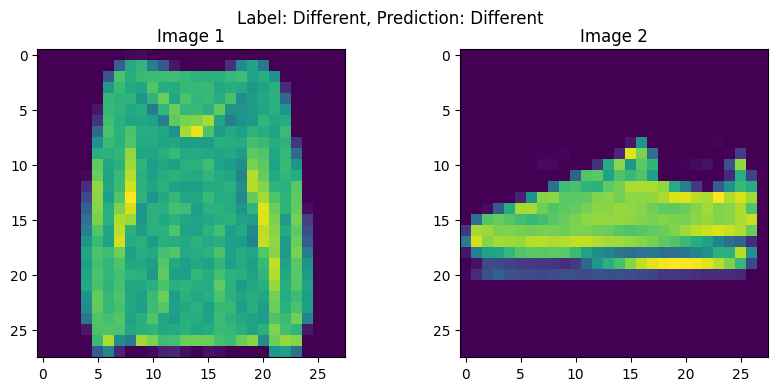

In [17]:
import matplotlib.pyplot as plt

def plot_images(image1, image2, label, pred):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.suptitle(f"Label: {'Same' if label == 1 else 'Different'}, Prediction: {'Same' if pred >= 0.5 else 'Different'}")
    plt.show()

# Predikce na testovacích datech
predictions = model.predict([test_pairs[:, 0], test_pairs[:, 1]])

# Zobrazíme prvních 10 párů obrázků
for i in range(100):
    plot_images(test_pairs[i, 0], test_pairs[i, 1], test_y[i], predictions[i])


In [27]:
[i[0] for i in np.round(predictions)]

[1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0

In [21]:
test_y 

array([1, 0, 1, ..., 0, 1, 0])

In [29]:
sum([i == j for i,j in zip(test_y, [i[0] for i in np.round(predictions)])])/len(test_y)

0.92925